# RESNET ARCHITECTURE IMPLEMENTATION

<P>Generally, CNN beased models face the problems of vanishing gradient and degradion (Adding more layers to a sufficiently deep neural network would first see saturation in accuracy and then the accuracy degrades) problems. Therefore, RESNET and other dense residual networks rectifies these errors while training.<P>
<p>In this notebook we have implemented RESNET architecture to classify the images from fashion mnist dataset. This notebook shows the implementation of a very complex architecture consisting of more than 25 layers.</p>

### PREPARATION OF DATA

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import tensorflow as tf
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras import applications
from skimage.transform import resize
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential,Model,load_model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras import activations
from tensorflow.keras import Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Add

In [12]:
dataset = np.load('fashion_mnist_dataset_train.npy', allow_pickle=True)
data_dict = np.array(dataset)

values = data_dict[()]['features']
labels = data_dict[()]['target']

features = []
for i in range(60000):
    features.append(values[i].flatten())
features = np.array(features)

final_features = pd.DataFrame(features)

arr = []
for image in features:
    image_temp = image.reshape((28,28))
    new_image = resize(image_temp, (32, 32))
    arr.append((new_image.reshape(1,32*32)))
    
new_arr = []
for i in range(60000):
    new_arr.append(arr[i][0])

new_img_data = pd.DataFrame(new_arr, index=np.arange(60000), columns=np.arange(1024))
new_img_data

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000138,0.000138,0.001149,0.002987,0.000751,0.011259,0.029335,...,0.483058,0.519485,0.332475,0.059835,0.000337,0.000214,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002390,...,0.002681,0.003447,0.000230,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.003355,0.019623,0.043857,0.142371,...,0.037975,0.032093,0.025015,0.006985,0.000919,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037638,...,0.013940,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
59996,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
59997,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011749,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
59998,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000260,0.003906,0.013725,...,0.209007,0.188986,0.031357,0.003768,0.002696,0.001716,0.0,0.0,0.0,0.0


In [13]:
labels = pd.DataFrame(labels, columns = ['output'])

categorical_cols = ['output']
encoder = OneHotEncoder(categories = "auto", handle_unknown="error", sparse = False)
encoded_labels = encoder.fit_transform(labels[categorical_cols])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(new_img_data, encoded_labels, test_size = 0.1, random_state = 0)
X_train = np.array(X_train)
X_test = np.array(X_test)
X_train = X_train.reshape((X_train.shape[0], 32, 32, 1))
X_test = X_test.reshape((X_test.shape[0], 32, 32, 1))

## RESNET ARCHITECTURE

In [15]:
def res_identity(x, filters): 
  #renet block where dimension doesnot change.
  #The skip connection is just simple identity conncection
  #we will have 3 blocks and then input will be added

  x_skip = x # this will be used for addition with the residual block 
  f1, f2 = filters

  #first block 
  x = Conv2D(f1, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  #second block # bottleneck (but size kept same with padding)
  x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  # third block activation used after adding the input
  x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  # x = Activation(activations.relu)(x)

  # add the input 
  x = Add()([x, x_skip])
  x = Activation(activations.relu)(x)

  return x

In [16]:
def res_conv(x, s, filters):
  '''
  here the input size changes''' 
  x_skip = x
  f1, f2 = filters

  # first block
  x = Conv2D(f1, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x)
  # when s = 2 then it is like downsizing the feature map
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  # second block
  x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  #third block
  x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)

  # shortcut 
  x_skip = Conv2D(f2, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x_skip)
  x_skip = BatchNormalization()(x_skip)

  # add 
  x = Add()([x, x_skip])
  x = Activation(activations.relu)(x)

  return x

In [32]:
def resnet50():

  input_im = Input(shape=(32,32,1)) # cifar 10 images size
  x = ZeroPadding2D(padding=(3, 3))(input_im)

  # 1st stage
  # here we perform maxpooling, see the figure above

  x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)
  x = MaxPooling2D((3, 3), strides=(2, 2))(x)

  #2nd stage 
  # frm here on only conv block and identity block, no pooling

  x = res_conv(x, s=1, filters=(64, 256))
  x = res_identity(x, filters=(64, 256))

  # 3rd stage

  x = res_conv(x, s=2, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))

  # 4th stage

  x = res_conv(x, s=2, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))

  # 5th stage

  x = res_identity(x, filters=(512, 1024))
  x = res_identity(x, filters=(512, 1024))

  # ends with average pooling and dense connection

  x = AveragePooling2D((2, 2), padding='same')(x)

  x = Flatten()(x)
  x = Dense(5, activation='softmax', kernel_initializer='he_normal')(x) #multi-class

  # define the model 

  model = Model(inputs=input_im, outputs=x, name='Resnet50')

  return model

In [33]:
final = resnet50()

In [34]:
final.summary()

Model: "Resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_7 (ZeroPadding2D (None, 38, 38, 1)    0           input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_98 (Conv2D)              (None, 16, 16, 64)   3200        zero_padding2d_7[0][0]           
__________________________________________________________________________________________________
batch_normalization_98 (BatchNo (None, 16, 16, 64)   256         conv2d_98[0][0]                  
___________________________________________________________________________________________

In [38]:
final.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='val_loss', patience = 5)

filepath = 'best_model_tryerror.wts.h5'

fitted_model = final.fit(X_train, y_train, epochs = 8, batch_size = 64, validation_split = 0.10, callbacks = [ tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto'), [callback]])

Epoch 1/8
760/760 [==============================] - ETA: 0s - loss: 3.1228 - accuracy: 0.7956
Epoch 00001: val_loss improved from inf to 1.74545, saving model to best_model_tryerror.wts.h5
760/760 [==============================] - 1017s 1s/step - loss: 3.1228 - accuracy: 0.7956 - val_loss: 1.7454 - val_accuracy: 0.6900
Epoch 2/8
760/760 [==============================] - ETA: 0s - loss: 1.1334 - accuracy: 0.8211
Epoch 00002: val_loss did not improve from 1.74545
760/760 [==============================] - 1023s 1s/step - loss: 1.1334 - accuracy: 0.8211 - val_loss: 4.4594 - val_accuracy: 0.4974
Epoch 3/8
760/760 [==============================] - ETA: 0s - loss: 0.9494 - accuracy: 0.8364
Epoch 00003: val_loss improved from 1.74545 to 1.32349, saving model to best_model_tryerror.wts.h5
760/760 [==============================] - 898s 1s/step - loss: 0.9494 - accuracy: 0.8364 - val_loss: 1.3235 - val_accuracy: 0.7620
Epoch 4/8
760/760 [==============================] - ETA: 0s - loss: 0.8

## PERFORMANCE METRICS

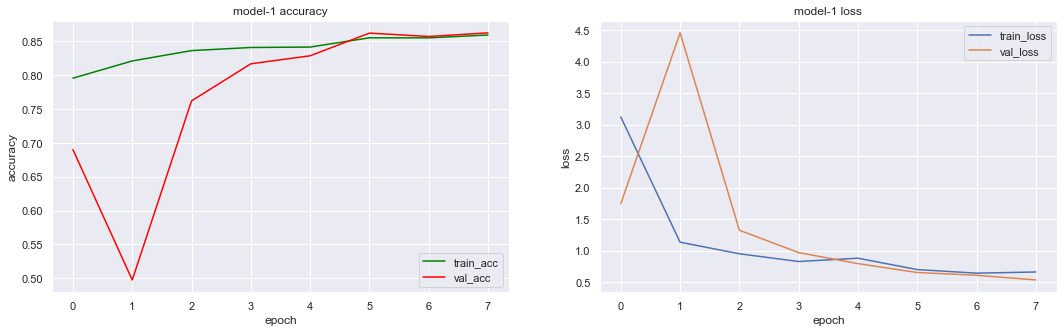

In [39]:
fig = plt.figure(figsize=(18,5))
# summarize history for accuracy
plt.subplot(121)
plt.plot(fitted_model.history['accuracy'], c = 'green', label = 'train_acc')
plt.plot(fitted_model.history['val_accuracy'], c = 'red', label = 'val_acc')
plt.title('model-1 accuracy')
plt.ylabel('accuracy')
plt.legend()
plt.xlabel('epoch')

plt.subplot(122)
# summarize history for loss
plt.plot(fitted_model.history['loss'], label = 'train_loss')
plt.plot(fitted_model.history['val_loss'], label = 'val_loss')
plt.title('model-1 loss')
plt.ylabel('loss')
plt.legend()
plt.xlabel('epoch')
plt.show()

In [40]:
print("Mean val acc:", np.mean(fitted_model.history['val_accuracy']))
print("Mean val loss:", np.mean(fitted_model.history['val_loss']))
print("Mean train acc:", np.mean(fitted_model.history['accuracy']))
print("Mean train loss:", np.mean(fitted_model.history['loss']))

Mean val acc: 0.7721296213567257
Mean val loss: 1.3855202123522758
Mean train acc: 0.8381892964243889
Mean train loss: 1.1139933988451958


In [42]:
y_pred = final.predict(X_test)

for i in range(0,len(y_pred)):
    temp = max(y_pred[i])
    for j in range(5):
        if y_pred[i][j] == temp:
            y_pred[i][j] = 1
        else:
            y_pred[i][j] = 0 
            
true_values = []
for i in range(0, len(y_test)):
    for j in range(5):
        if y_test[i][j] == 1:
            if j == 0:
                true_values.append(1)
            elif j == 1:
                true_values.append(2)
            elif j == 2:
                true_values.append(3)
            elif j == 3:
                true_values.append(4)
            elif j == 4:
                true_values.append(5)

result = []
for i in range(0, len(y_pred)):
    for j in range(5):
        if y_pred[i][j] == 1:
            if j == 0:
                result.append(1)
            elif j == 1:
                result.append(2)
            elif j == 2:
                result.append(3)
            elif j == 3:
                result.append(4)
            elif j == 4:
                result.append(5)

In [43]:
from sklearn.metrics import confusion_matrix, accuracy_score
score =accuracy_score(true_values, result) 
print(f'The test set accuracy obtained: {score*100} %')

The test set accuracy obtained: 87.05000000000001 %
